In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
local_dir = 's18-transformer-speeding-up-strategy'
repo_url = 'https://github.com/aakashvardhan/s18-transformer-speeding-up-strategy.git'

# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone --quiet {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

In [3]:
import sys
sys.path.append('/content/s18-transformer-speeding-up-strategy')

In [4]:
!pip install -q -r /content/s18-transformer-speeding-up-strategy/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.4 MB/s eta 0:00:00


In [5]:
%cd /content/s18-transformer-speeding-up-strategy

/content/s18-transformer-speeding-up-strategy


In [6]:
from config_file import get_config
from main import main

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Directory 'weights' created!
Seed set to 42...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Max length of the source sentence : 45
Max length of the source target : 41
DataModule initialized...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of the source sentence : 45
Max length of the source target : 41
Saving model to weights/tmodel_0.pt
Saving model to weights/tmodel_0.pt


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finding best initial lr:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO: `Trainer.fit` stopped: `max_steps=18` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=18` reached.
INFO: Learning rate set to 0.005994842503189409
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005994842503189409
INFO: Restoring states from the checkpoint path at weights/.lr_find_693b5465-03b5-4ba1-8728-d43d8de29292.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at weights/.lr_find_693b5465-03b5-4ba1-8728-d43d8de29292.ckpt
INFO: Restored all states from the checkpoint at weights/.lr_find_693b5465-03b5-4ba1-8728-d43d8de29292.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at weights/.lr_find_693b5465-03b

Suggested learning rate: 0.005994842503189409


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /content/s18-transformer-speeding-up-strategy/weights exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 53.1 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
53.1 M    Trainable params
0         Non-trainable params
53.1 M    Total params
212.390   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 53.1 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------

Max length of the source sentence : 45
Max length of the source target : 41


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: Through two luminous windows saw
    TARGET: attraverso a due finestre luminose,
 PREDICTED: dissuggellò Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia perito Isaia perito perito perito perito perito perito Isaia perito perito perito perito perito perito perito dissuggellò compita perito dissuggellò dissuggellò dissuggellò dissuggellò Isaia perito Isaia perito Isaia perito dissuggellò Isaia dissuggellò Isaia Isaia Isaia Isaia Isaia dissuggellò Isaia Isaia Isaia Isaia Isaia dissuggellò Isaia dissuggellò Isaia perito Isaia perito dissuggellò Isaia dissuggellò Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia dissuggellò Isaia Isaia Isaia Isaia Isaia dissuggellò Isaia dissuggellò Isaia dissuggellò Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia Isaia 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


AssertionError: Loss is NaN

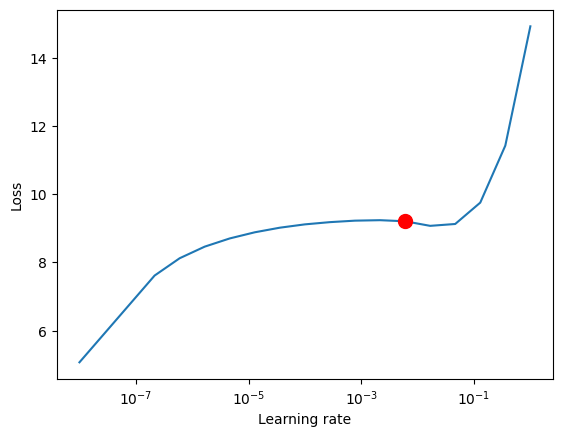

In [7]:
cfg = get_config()
cfg['batch_size'] = 24
cfg['num_epochs'] = 18
main(cfg,debug=False)

In [ ]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/s18-transformer-speeding-up-strategy/lightning_logs